In [1]:
import os
import copy
from tqdm import tqdm
import networkx as nx
import torch
import torch.nn as nn
import numpy as np
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from tqdm import tqdm
import community as community_louvain
from networkx.algorithms.community import greedy_modularity_communities, label_propagation_communities, louvain_communities

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

/users/Min/miniconda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/Min/miniconda/lib/python3.11/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /users/Min/miniconda/lib/python3.11/site-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl
  warnings.warn(


1.13.1+cu117


In [2]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print()
print('='*80)

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [3]:
data.x, torch.min(data.x), torch.max(data.x)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor(0.),
 tensor(1.))

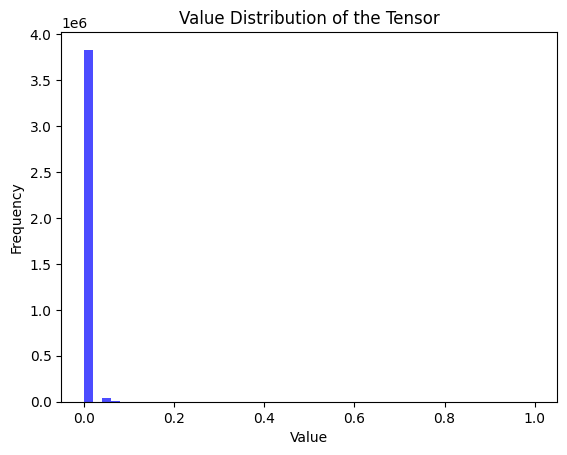

In [4]:
feats = data.x.numpy()
feats = feats.flatten()

# 创建直方图
plt.hist(feats, bins=50, color='blue', alpha=0.7)
plt.title('Value Distribution of the Tensor')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [5]:
# from torch_geometric.data import Data

# def community_detection(data, model_name, resolution):
#     # Step 1: Convert Cora dataset to a NetworkX graph
#     G = nx.Graph()
#     for i in range(data.edge_index.shape[1]):
#         source = data.edge_index[0, i].item()
#         target = data.edge_index[1, i].item()
#         G.add_edge(source, target)

#     # Step 2: Apply Louvain community detection
#     if model_name == 'louvain':
#         partition = community_louvain.best_partition(G)
#     elif model_name == 'greedy_modularity':
#         communities = greedy_modularity_communities(G)
#         partition = {}
#         for idx, community in enumerate(communities):
#             for node in community:
#                 partition[node] = idx
#     print(partition)
#     # Step 3: Create a new graph based on community assignments
#     # unique_partitions = np.unique(list(partition.values()))
#     community_masks = torch.zeros((data.num_nodes, len(partition)), dtype=torch.float32)
#     subgraphs = []

#     for idx, community_id in enumerate(partition):
#         # nodes_in_community = list(idx)
#         nodes_in_community = [node for node, community in partition.items() if community == community_id]
#         community_masks[nodes_in_community, idx] = 1

#         # Extract subgraph for each community
#         community_subgraph = G.subgraph(nodes_in_community)
#         community_edges = torch.tensor(list(community_subgraph.edges)).t().contiguous()
#         community_edge_index = torch.cat([community_edges, community_edges.flip(0)], dim=-1)
#         community_data = Data(
#             x=data.x[nodes_in_community],
#             edge_index=community_edge_index,
#             y=data.y[nodes_in_community],
#             train_mask=data.train_mask[nodes_in_community],
#             val_mask=data.val_mask[nodes_in_community],
#             test_mask=data.test_mask[nodes_in_community]
#         )
#         subgraphs.append(community_data)

#     return partition, community_masks, subgraphs

In [6]:
from torch_geometric.data import Data

def community_detection(data, model_name, resolution):
    # Step 1: Convert Cora dataset to a NetworkX graph
    G = nx.Graph()
    for i in range(data.edge_index.shape[1]):
        source = data.edge_index[0, i].item()
        target = data.edge_index[1, i].item()
        G.add_edge(source, target)

    # Step 2: Apply Louvain community detection
    if model_name == 'louvain':
        partition = louvain_communities(G, resolution)
    elif model_name == 'greedy_modularity':
        communities = greedy_modularity_communities(G)
        partition = {}
        for idx, community in enumerate(communities):
            for node in community:
                partition[node] = idx
    partition1 = {}
    for index, item in enumerate(partition):
        for value in item:
            partition1[value] = index
    unique_partitions = np.unique(list(partition1.values()))
    # Step 3: Create a new graph based on community assignments
    # unique_partitions = np.unique(list(partition.values()))
    community_masks = torch.zeros((data.num_nodes, len(unique_partitions)), dtype=torch.float32)
    subgraphs = []

    for idx, community_id in enumerate(unique_partitions):
        nodes_in_community = [node for node, community in partition1.items() if community == community_id]
        community_masks[nodes_in_community, idx] = 1

        # Extract subgraph for each community
        community_subgraph = G.subgraph(nodes_in_community)
        community_edges = torch.tensor(list(community_subgraph.edges)).t().contiguous()
        community_edge_index = torch.cat([community_edges, community_edges.flip(0)], dim=-1)
        community_data = Data(
            x=data.x[nodes_in_community],
            edge_index=community_edge_index,
            y=data.y[nodes_in_community],
            train_mask=data.train_mask[nodes_in_community],
            val_mask=data.val_mask[nodes_in_community],
            test_mask=data.test_mask[nodes_in_community]
        )
        subgraphs.append(community_data)

    return partition1, community_masks, subgraphs

In [7]:
import torch_geometric.transforms as T

# Load the Cora dataset
cora_dataset = Planetoid(root='cora', name='Cora', transform=T.NormalizeFeatures())
data = cora_dataset[0]

# Apply community detection
partition, community_masks, subgraphs = community_detection(data, model_name='louvain', resolution=0.5)


In [8]:
partition

{997: 0,
 1991: 0,
 1768: 0,
 1837: 0,
 2325: 0,
 182: 0,
 183: 0,
 508: 0,
 2544: 1,
 3: 1,
 208: 2,
 7: 2,
 2661: 3,
 1318: 3,
 2662: 3,
 1001: 3,
 12: 3,
 99: 4,
 26: 4,
 2604: 4,
 2454: 4,
 2455: 4,
 122: 4,
 123: 4,
 127: 4,
 1594: 5,
 31: 5,
 2048: 6,
 1030: 6,
 519: 6,
 10: 6,
 1551: 6,
 1552: 6,
 530: 6,
 18: 6,
 1045: 6,
 1560: 6,
 1561: 6,
 1564: 6,
 542: 6,
 2591: 6,
 2078: 6,
 2080: 6,
 2081: 6,
 2082: 6,
 36: 6,
 1571: 6,
 2086: 6,
 2084: 6,
 2085: 6,
 2087: 6,
 2598: 6,
 2089: 6,
 2090: 6,
 2093: 6,
 2094: 6,
 2088: 6,
 556: 6,
 1584: 6,
 2096: 6,
 1072: 6,
 2092: 6,
 563: 6,
 2106: 6,
 2107: 6,
 1088: 6,
 1089: 6,
 581: 6,
 589: 6,
 1622: 6,
 1623: 6,
 1624: 6,
 2143: 6,
 608: 6,
 1638: 6,
 102: 6,
 103: 6,
 1640: 6,
 109: 6,
 112: 6,
 1651: 6,
 1140: 6,
 1656: 6,
 121: 6,
 1146: 6,
 1144: 6,
 124: 6,
 126: 6,
 133: 6,
 1158: 6,
 1670: 6,
 136: 6,
 134: 6,
 139: 6,
 655: 6,
 656: 6,
 1681: 6,
 1682: 6,
 660: 6,
 153: 6,
 1180: 6,
 1705: 6,
 1193: 6,
 2218: 6,
 1196: 6,
 

In [9]:
community_masks, community_masks.shape

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([2708, 104]))

In [10]:
subgraphs[0]

Data(x=[8, 1433], edge_index=[2, 18], y=[8], train_mask=[8], val_mask=[8], test_mask=[8])

In [11]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, alpha):
        super().__init__()
        torch.manual_seed(42)
        self.alpha = alpha
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        out = self.conv2(x, edge_index)
        return x, out

In [12]:
model = GCN(data.num_features, 512, dataset.num_classes, alpha=0.01)
model

GCN(
  (conv1): GCNConv(1433, 512)
  (conv2): GCNConv(512, 7)
)

In [13]:
x, out = model(data.x, data.edge_index)
x, x.shape

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0036],
         [0.0000, 0.0000, 0.0015,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0212, 0.0000,  ..., 0.0071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0237, 0.0000, 0.0000],
         [0.0000, 0.0070, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        grad_fn=<MulBackward0>),
 torch.Size([2708, 512]))

In [14]:
out, out.shape

(tensor([[ 0.0070, -0.0019,  0.0010,  ..., -0.0016, -0.0019,  0.0007],
         [-0.0008, -0.0002,  0.0025,  ..., -0.0048, -0.0040,  0.0066],
         [ 0.0084, -0.0072, -0.0010,  ...,  0.0033, -0.0011, -0.0005],
         ...,
         [-0.0040,  0.0138, -0.0039,  ..., -0.0004, -0.0018, -0.0028],
         [ 0.0102, -0.0034, -0.0043,  ...,  0.0041, -0.0012, -0.0017],
         [ 0.0065, -0.0052, -0.0023,  ...,  0.0018, -0.0004, -0.0034]],
        grad_fn=<AddBackward0>),
 torch.Size([2708, 7]))

In [15]:
community_masks, community_masks[:,0], community_masks[:,1]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [16]:
x, x[0,:]

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0036],
         [0.0000, 0.0000, 0.0015,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0212, 0.0000,  ..., 0.0071, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0237, 0.0000, 0.0000],
         [0.0000, 0.0070, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
        grad_fn=<MulBackward0>),
 tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0476e-03, 0.0000e+00, 3.3942e-03,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7982e-03, 1.2336e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [17]:
rows = []
cols = torch.arange(community_masks.size(1))
for col in cols:
    row = (community_masks[:, col] == 1).nonzero().view(-1)
    rows.append(row)

rows

[tensor([ 182,  183,  508,  997, 1768, 1837, 1991, 2325]),
 tensor([   3, 2544]),
 tensor([  7, 208]),
 tensor([  12, 1001, 1318, 2661, 2662]),
 tensor([  26,   99,  122,  123,  127, 2454, 2455, 2604]),
 tensor([  31, 1594]),
 tensor([  10,   18,   36,  102,  103,  109,  112,  121,  124,  126,  133,  134,
          136,  139,  153,  234,  236,  294,  302,  303,  306,  308,  317,  318,
          329,  342,  350,  384,  406,  407,  409,  416,  426,  452,  459,  476,
          484,  487,  505,  519,  530,  542,  556,  563,  581,  589,  608,  655,
          656,  660,  695,  699,  719,  741,  762,  773,  831,  836,  852,  859,
          887,  910,  937,  943,  945,  948,  958,  980, 1009, 1011, 1012, 1030,
         1045, 1072, 1088, 1089, 1140, 1144, 1146, 1158, 1180, 1193, 1196, 1245,
         1248, 1251, 1253, 1258, 1270, 1289, 1304, 1335, 1336, 1337, 1346, 1367,
         1411, 1448, 1452, 1459, 1465, 1490, 1505, 1506, 1512, 1551, 1552, 1560,
         1561, 1564, 1571, 1572, 1584, 1622, 

In [18]:
x[rows[-1][0],:], x[rows[-1][1],:], x[rows[-1][0],:].shape, x[rows[-1][1],:].shape

(tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8376e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0363e-03, 0.0000e+00,
         3.5450e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.5845e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 4.1780e-03, 5.2496e-03, 0.0000e+00, 6.8465e-04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.1806e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2987e-03,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 2.8890e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.6872e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0357e-02,
         0.0000e+00, 5.8086e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e

In [19]:
input1,input2 = x[rows[-2][0],:].unsqueeze(dim=1), x[rows[-1][1],:].unsqueeze(dim=1)

simi_tensor = F.cosine_similarity(input1,input2, dim=1, eps=1e-8)
dist_tensor = 1 - simi_tensor

simi_tensor, dist_tensor, simi_tensor.shape

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0.,

In [20]:
torch.mean(simi_tensor), torch.mean(dist_tensor)

(tensor(0.0918, grad_fn=<MeanBackward0>),
 tensor(0.9082, grad_fn=<MeanBackward0>))

In [21]:
data.y[rows[-2][0]], data.y[rows[-1][1]]

(tensor(3), tensor(4))

In [22]:
model

GCN(
  (conv1): GCNConv(1433, 512)
  (conv2): GCNConv(512, 7)
)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
cross_entropy = torch.nn.CrossEntropyLoss()

In [24]:
node_idx = torch.arange(data.x.size(0)).unsqueeze(dim=0)
node_idx, node_idx.shape

(tensor([[   0,    1,    2,  ..., 2705, 2706, 2707]]), torch.Size([1, 2708]))

In [25]:
community_masks.shape

torch.Size([2708, 104])

In [26]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.savefig('figs/cora_1025.png')


def accuracy(y_pred, y_true):
    
    correct = y_pred.eq(y_true).double()
    correct = correct.sum().item()
    return correct / len(y_true)

### 关键思路：
1. 找到节点所属社团（在community_mask里通过行号关联找到非零列号）；
2. 计算节点表示和（根据非零列号索引集合对应的）相同社团节点表示两者的相似性和距离，同时可以计算不同社团之间的相似性和距离，我们希望相同社团的相似性高，不同社团对应的相似性低；
3. 基于此构造loss函数中的归一化项，然后结合交叉熵用于节点分类，实现模型的训练和学习；


In [27]:
# 先构建社团图
def construct_community_graph(edges, community_assignments):

    # 1. 创建新的社团图
    community_graph = nx.Graph()

    # 2. 添加社团节点
    for community_id in set(community_assignments.values()):
        community_graph.add_node(community_id)

    # 3. 构建社团之间的连接关系
    for edge in edges:
        node1, node2 = edge
        community1, community2 =community_assignments.get(node1, None), community_assignments.get(node2, None)

        # 确保节点属于哪个社团
        if community1 is not None and community2 is not None:
            if community1 != community2:
                # 社团1和社团2之间没有边，添加一条边
                if not community_graph.has_edge(community1, community2):
                    community_graph.add_edge(community1, community2)

    # 这里采用社团图的最短路径距离
    community_distances = dict(nx.all_pairs_shortest_path_length(community_graph))

    # 对于每个社团，根据最短距离选取离得最远的社团并返回各自对应的社团编号
    max_dis_communities = {}
    for com in community_distances:
        sorted_items = sorted(community_distances[com].items(), key=lambda item: item[1], reverse=True)
        max_com = sorted_items[0][0]
        max_dis_communities[com] = max_com

    return community_graph, community_distances, max_dis_communities




# 示例数据
edges = [(1, 2), (1, 3), (2, 4), (2, 3), (4, 5), (4, 6), (5, 6), (7, 8)]
community_assignments = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1}

# 构建社团图和计算社团之间的距离
community_graph, community_distances, max_dis_communities = construct_community_graph(edges, community_assignments)



# 输出社团图和社团之间的距离
print("社团图的节点：", community_graph.nodes)
print("社团之间的距离：", community_distances)
print("对应最远社团：", max_dis_communities)

社团图的节点： [0, 1]
社团之间的距离： {0: {0: 0, 1: 1}, 1: {1: 0, 0: 1}}
对应最远社团： {0: 1, 1: 0}


In [28]:
G = nx.Graph()
for i in range(data.edge_index.shape[1]):
    source = data.edge_index[0, i].item()
    target = data.edge_index[1, i].item()
    G.add_edge(source, target)
print(nx.components.is_connected(G))
list(G.edges)

False


[(0, 633),
 (0, 1862),
 (0, 2582),
 (633, 1701),
 (633, 1866),
 (1862, 926),
 (1862, 1701),
 (1862, 2582),
 (2582, 1166),
 (1, 2),
 (1, 652),
 (1, 654),
 (2, 332),
 (2, 1454),
 (2, 1666),
 (2, 1986),
 (652, 470),
 (332, 665),
 (332, 2003),
 (332, 2122),
 (332, 2615),
 (1666, 48),
 (1666, 49),
 (1666, 606),
 (1666, 1662),
 (1666, 2381),
 (1986, 45),
 (1986, 68),
 (1986, 71),
 (1986, 151),
 (1986, 160),
 (1986, 179),
 (1986, 201),
 (1986, 215),
 (1986, 232),
 (1986, 335),
 (1986, 366),
 (1986, 391),
 (1986, 460),
 (1986, 476),
 (1986, 519),
 (1986, 566),
 (1986, 673),
 (1986, 681),
 (1986, 743),
 (1986, 745),
 (1986, 792),
 (1986, 899),
 (1986, 968),
 (1986, 1023),
 (1986, 1095),
 (1986, 1127),
 (1986, 1149),
 (1986, 1166),
 (1986, 1434),
 (1986, 1453),
 (1986, 1558),
 (1986, 1574),
 (1986, 1697),
 (1986, 1704),
 (1986, 1709),
 (1986, 1812),
 (1986, 1859),
 (1986, 1870),
 (1986, 1873),
 (1986, 1875),
 (1986, 1876),
 (1986, 1987),
 (1986, 1988),
 (1986, 1989),
 (1986, 1990),
 (1986, 1991)

In [44]:
# 只考虑不同社团的情况
def get_neg_node(data, node, partition, rows):

    # Step 1: Convert Cora dataset to a NetworkX graph
    G = nx.Graph()
    for i in range(data.edge_index.shape[1]):
        source = data.edge_index[0, i].item()
        target = data.edge_index[1, i].item()
        G.add_edge(source, target)
    edges = list(G.edges)

    # 选取最远距离的社团对应的节点作为负样本
    community_graph, community_distances, max_dis_communities = construct_community_graph(edges, partition)

    # print(community_distances)
    # print()
    # print(max_dis_communities)

    # 创建一个新的字典，值是列表
    flipped_partition = {}
    for key, value in partition.items():
        if value not in flipped_partition:
            flipped_partition[value] = [key]
        else:
            flipped_partition[value].append(key)

    # print(flipped_partition)
    
    neg_node = []
    if len(neg_node) == rows.shape[0]:
        neg_node = torch.stack(neg_node)
        return neg_node
    
    else:
        
        neg_node = flipped_partition[max_dis_communities[partition[node.item()]]]
        neg_node = torch.tensor(neg_node)
        # print(neg_node)
        if not node in neg_node:
            # if neg_node.size(0) <= 1:
            #     return neg_node
            # else:
            #     neg_node = torch.stack(neg_node)
            return neg_node
            
        else:
            neg_node = []
            for target_node in torch.arange(data.x.size(0)):
                if target_node != node:
                    if torch.eq(rows, target_node).any():
                        continue
                    else:
                        neg_node.append(target_node)
                if len(neg_node) == rows.shape[0]:
                    break
            
            neg_node = torch.stack(neg_node)
            return neg_node

# # 只考虑不同社团的情况
# def get_neg_node(data, node, row):
#     neg_node = []
#     if len(neg_node) == row.size(0):
#         neg_node = torch.stack(neg_node)
#         return neg_node
            
#     else:
#         for target_node in torch.arange(data.x.size(0)):
#             if target_node != node:
#                 if torch.eq(row, target_node).any():
#                     continue
#                 else:
#                     neg_node.append(target_node)
#             if len(neg_node) == row.size(0):
#                 break
        
#         neg_node = torch.stack(neg_node)
#         # print('*'*100)
#         # print(neg_node, neg_node.shape)
#         return neg_node

# def get_neg_node(data, node, row):
#     # 创建一个布尔掩码，标记哪些节点是正样本
#     is_positive = torch.zeros(data.num_nodes, dtype=torch.bool)
#     is_positive[row] = True

#     # 通过异或操作找到负样本节点
#     is_negative = ~is_positive

#     # 去除自身节点
#     is_negative[node] = False

#     # 获取负样本节点的索引
#     neg_node = torch.nonzero(is_negative, as_tuple=False).squeeze()
#     print('*'*100)
#     print(neg_node, neg_node.shape)
#     return neg_node


In [45]:
subgraphs[0], subgraphs[1]

(Data(x=[8, 1433], edge_index=[2, 18], y=[8], train_mask=[8], val_mask=[8], test_mask=[8]),
 Data(x=[2, 1433], edge_index=[2, 2], y=[2], train_mask=[2], val_mask=[2], test_mask=[2]))

In [56]:
best_val_acc = 0
num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    emb, out = model(data.x, data.edge_index)
    loss1 = cross_entropy(out[data.train_mask], data.y[data.train_mask])
    same_com_cos_sim, diff_com_cos_sim = [], []
    
    emb = emb - torch.mean(emb)
    for node in torch.arange(data.x.size(0))[data.train_mask]:
        # for the same community
        col = (community_masks[node, :] == 1).nonzero().view(-1)
        
        rows = (community_masks[:, col] == 1).nonzero()[:,0].view(-1)
       
        cos_sims = []
        for row in rows:
            if node != row:
                cos_sim = torch.cosine_similarity(emb[node,:], emb[row,:], dim=0)
                cos_sims.append(cos_sim)
        cos_sims = torch.stack(cos_sims)
        cos_sims = F.normalize(cos_sims, dim=0)
        # print(cos_sims, cos_sims.shape)
        cos_sims = torch.mean(cos_sims)
        
        same_com_cos_sim.append(cos_sims.unsqueeze(dim=0))

        # for different communities
        neg_node = get_neg_node(data, node, partition, rows)
        neg_cos_sims = []
        for neg in neg_node:
             neg_cos_sim = F.cosine_similarity(emb[node,:], emb[neg,:], dim=0)
             neg_cos_sims.append(neg_cos_sim)
        neg_cos_sims = torch.stack(neg_cos_sims)
        neg_cos_sims = F.normalize(neg_cos_sims, dim=0)
        neg_cos_sims = torch.mean(neg_cos_sims)
        
        diff_com_cos_sim.append(neg_cos_sims.unsqueeze(dim=0))

    
    same_com_cos_sim = torch.stack(same_com_cos_sim)
    same_com_cos_sim = same_com_cos_sim.squeeze(dim=1)
    same_com_dis = 1 - same_com_cos_sim

    diff_com_cos_sim = torch.stack(diff_com_cos_sim)
    diff_com_cos_sim = diff_com_cos_sim.squeeze(dim=1)

    diff_com_dis = 1 - diff_com_cos_sim

    loss2 = diff_com_dis - same_com_dis
    loss2 = torch.mean(loss2)
    

    
    

    loss = torch.mean(loss1) - model.alpha * loss2
    # print('=======loss:')
    print(loss, loss1, loss2)
    # loss  =loss1
    loss.backward()
    optimizer.step()

    # 模型验证
    best_val_acc = 0
    with torch.no_grad():
        model.eval()
        emb, out = model(data.x, data.edge_index)
        emb = emb - torch.mean(emb)
        val_loss1 = cross_entropy(out[data.val_mask], data.y[data.val_mask])
        same_com_cos_sim, diff_com_cos_sim = [], []
        for node in torch.arange(data.x.size(0))[data.val_mask]:
            # for nodes from the same community
            col = (community_masks[node, :] == 1).nonzero().view(-1)
            rows = (community_masks[:, col] == 1).nonzero()[:,0].view(-1)

            cos_sims = []
            for row in rows:
                if node != row:
                    cos_sim = torch.cosine_similarity(emb[node,:], emb[row,:], dim=0)
                    cos_sims.append(cos_sim)

            cos_sims = torch.stack(cos_sims)
            cos_sims = F.normalize(cos_sims, dim=0)
            cos_sims = torch.mean(cos_sims)
            same_com_cos_sim.append(cos_sims.unsqueeze(dim=0))

            # for nodes from different communities
            neg_node = get_neg_node(data, node, partition, rows)
            neg_cos_sims = []
            for neg in neg_node:
                neg_cos_sim = F.cosine_similarity(emb[node,:], emb[neg,:], dim=0)
                neg_cos_sims.append(neg_cos_sim)
            neg_cos_sims = torch.stack(neg_cos_sims)
            neg_cos_sims = F.normalize(neg_cos_sims, dim=0)
            neg_cos_sims = torch.mean(neg_cos_sims)
            
            diff_com_cos_sim.append(neg_cos_sims.unsqueeze(dim=0))

        same_com_cos_sim = torch.stack(same_com_cos_sim)
        same_com_cos_sim = same_com_cos_sim.squeeze(dim=1)
        same_com_dis = 1 - same_com_cos_sim

        diff_com_cos_sim = torch.stack(diff_com_cos_sim)
        diff_com_cos_sim = diff_com_cos_sim.squeeze(dim=1)
        diff_com_dis = 1 - diff_com_cos_sim
        

        val_loss2 = diff_com_dis - same_com_dis
        val_loss2 = torch.mean(val_loss2)
        
        val_loss = torch.mean(val_loss1) - model.alpha * val_loss2
        print(val_loss, val_loss1, val_loss2)
        
        val_pred = out.argmax(dim=1)
        val_acc = accuracy(val_pred[data.val_mask], data.y[data.val_mask])

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'models/best_1025.pth')

    if epoch % 2 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val ACC: {val_acc:.4f}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(loss.detach().numpy(), label='Train Loss')
plt.plot(val_loss.detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('figs/loss_1025.png')


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
model.eval()
# model = best_model
emb, out = model(data.x, data.edge_index)
test_pred = out.argmax(dim=1)
test_acc = accuracy(test_pred[data.test_mask], data.y[data.test_mask])
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8070
